In [1]:
import pandas as pd, numpy as np
import QTLfunctions as QTLfun
from sklearn import feature_selection as fs
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
## Define G ftn
import scipy.stats as ss
def gqtl(geno,pheno):
    df = pd.DataFrame([np.array(geno,dtype=float),
                       np.array(pheno,dtype=float)],
                      index=['Geno','Pheno']).T
    
    g, p, dof, expctd = ss.chi2_contingency(
                        pd.crosstab(df.Geno.values,df.Pheno.values),
                        lambda_="log-likelihood")
    return g#,p,dof,expctd

In [3]:
## Set relative regions of MAT locus
MAT = [1529240,1661861]

In [4]:
## Bring in centromeres datarame
cent_path = '/home/croth/Downloads/B3502/DATA/FungiDB-48_CneoformansJEC21_centromeres.csv'
centlocs = pd.read_csv(cent_path,index_col=0)
centlocs.head()

,Chromosome,Left,Right
0,1,942544,993056
1,2,860449,900038
2,3,806551,906800
3,4,222000,273992
4,5,784047,849321


In [5]:
## Bring in chromosome map
chrommap_path = '/home/croth/Downloads/B3502/DATA/chrommap.csv.gz'
chrommap = pd.read_csv(chrommap_path)
chrommap['Seqid'] = chrommap.Contig
chrommap.drop('Contig',axis=1,inplace=True)
chrommap['Chromosome'] = chrommap.index+1
chrommap = chrommap.merge(centlocs)
chrommap.head()

,Length,Cumlen,Midpts,Seqid,Chromosome,Left,Right
0,2300533,0,1150266.5,AE017341.1,1,942544,993056
1,1632307,2300533,3116686.5,AE017342.1,2,860449,900038
2,2105742,3932840,4985711.0,AE017343.1,3,806551,906800
3,1783081,6038582,6930122.5,AE017344.1,4,222000,273992
4,1507550,7821663,8575438.0,AE017345.1,5,784047,849321


In [6]:
## Bring in genotype dataframe
genopath = '../GENOTYPE/B3502_progeny_variants.csv.gz'
geno = pd.read_csv(genopath,
                   index_col=0)
geno.head()

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Minlen,Depth,Type,...,B04,B05,B06,B07,B08,B09,B10,B11,B12,B20
7713,AE017341.1,530127,87856.4,1.0,1,C.G,1,1,5440,snp,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
13742,AE017341.1,884617,51253.4,1.0,1,AGG.AGA,3,3,3444,snp,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
16507,AE017341.1,1032506,76943.9,1.0,1,T.C,1,1,5283,snp,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
22088,AE017341.1,1430787,11823.5,1.0,1,G.T,1,1,4119,snp,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25519,AE017341.1,1694543,80782.5,1.0,1,G.C,1,1,5795,snp,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [7]:
## Bring in phenotype data from Dr. Sheng Sun
phenopath = '../PHENOTYPE/202011_WGS_B3502Progeny_phenotypes.csv.gz'
pheno = pd.read_csv(phenopath)
pheno.index = pheno.Strain
pheno.tail()

,gDNA sample for WGS,Cross_Progeny,Phenotype on MS (N-no filamentation; Y-filamentation; L-giant cells; T-transgressive filamentation),Notes,Phenotype,Strain
Strain,,,,,,
B09,B_09,1. B3502A1_x_CF830_Random12,N,NaN,0.0,B09
B10,B_10,1. B3502A1_x_CF830_Random14,N,NaN,0.0,B10
B11,B_11,1. B3502A1_x_CF830_Random20,T,NaN,2.0,B11
B12,B_12,2. B3502B1_x_CF830_Random01,N,NaN,0.0,B12
B20,B_20,2. B3502B1_x_CF830_Random12,Y,"Replacing sample ""SS_20201123_H99_03""",1.0,B20


In [8]:
## Make additional phenotype groups 
## by binning Dr Sun's scores
## Define binning dictionarys
bidict = dict(zip([0,1,2,3],[0,1,1,1]))
tridict = dict(zip([0,1,2,3],[0,1,1,2]))

## Replace scores
pheno['Binary'] = pheno.Phenotype.replace(bidict)
pheno['Tertiary'] = pheno.Phenotype.replace(tridict)

## View restuls
pheno[[pheno.columns[2],'Phenotype','Binary','Tertiary']].drop_duplicates()

,Phenotype on MS (N-no filamentation; Y-filamentation; L-giant cells; T-transgressive filamentation),Phenotype,Binary,Tertiary
Strain,,,,
A01,N,0.0,0.0,0.0
A02,Y,1.0,1.0,1.0
A04,L,3.0,1.0,2.0
A05,N (with rare spots of T),0.0,0.0,0.0
A09,T,2.0,1.0,1.0


In [9]:
## Gather samples and unique testing sites
samples = sorted(pheno.Strain.tolist())

## Gather unique haplotypes for testing
loci = geno[samples].drop_duplicates()

In [15]:
## Here I have set the phenotype to a quadriaary phenotype
## Uncomment this to analyze a binary phenotype
## Filamentous vs nonfilamentous vs large cells
#pheno_label = 'Phenotype'
pheno_label = 'Binary'
#pheno_label = 'Tertiary'

## Copy loci df and append phenotype set above
#usnps = loci.copy().T
y = pheno.loc[samples,pheno_label].values
#usnps.shape

In [18]:
loci['G-stat'] = loci.apply(gqtl,args=[y],axis=1)

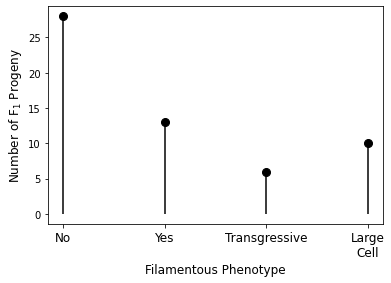

In [11]:
## Plot distribution of phenotypes
x,y = np.unique(pheno['Phenotype'].values,return_counts=True)

plt.vlines(x,0,y,color='k');
plt.plot(x,y,'o',color='k',ms=8);
plt.xticks(x,['No','Yes','Transgressive','Large\nCell'],fontsize=12)
plt.xlabel('Filamentous Phenotype',fontsize=12)
plt.ylabel('Number of F$_1$ Progeny',fontsize=12);

In [19]:
## QTL MAPPING!!!
## Single locus effect
#MIobs = fs.mutual_info_classif(usnps.values,usnps['Y'].values,
#                               discrete_features=True)
## append as column to snp dataframe
#res = usnps.T
#res['MIobs'] = MIobs

## Merge with genotype dataframe
res = geno.merge(loci)
res.head()

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Minlen,Depth,Type,...,B05,B06,B07,B08,B09,B10,B11,B12,B20,G-stat
0,AE017341.1,530127,87856.4,1.0,1,C.G,1,1,5440,snp,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.442542
1,AE017341.1,884617,51253.4,1.0,1,AGG.AGA,3,3,3444,snp,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.020926
2,AE017341.1,1032506,76943.9,1.0,1,T.C,1,1,5283,snp,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.013710
3,AE017341.1,1430787,11823.5,1.0,1,G.T,1,1,4119,snp,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.002457
4,AE017341.1,1694543,80782.5,1.0,1,G.C,1,1,5795,snp,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.846952


In [41]:
## Conduct permutations
## Establish genome-wide signfiance
perms = []
nperm = 1000
for i in range(nperm):
    
    temp = loci[samples].apply(gqtl,
                        args=[np.random.permutation(y)],
                               axis=1)
    
    perms.append(np.max(temp))

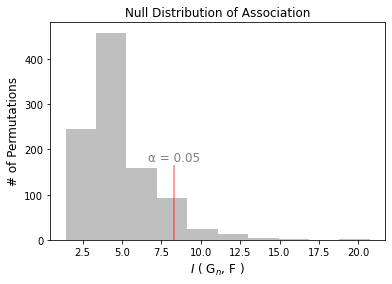

In [42]:
## Plot null distribution of association
plt.hist(perms,alpha=0.5,color='grey');
plt.xlabel('$I$ ( G$_n$, F )',fontsize=12);
plt.ylabel('# of Permutations',fontsize=12);
plt.title('Null Distribution of Association',fontsize=12);
alpha = 95 if nperm  == 1000 else 99
thres = np.percentile(perms,alpha)
plt.vlines(thres,0,nperm/6,color='r',alpha=0.5);
plt.text(thres,nperm/6,'\u03B1 = 0.05',fontsize=12,
         color='k',alpha=0.5,va='bottom',ha='center')
plt.savefig('../FIGURES/G_null_dist.png',
            dpi=100,bbox_inches='tight');

In [21]:
## Make chromsome plotting map
idxmap = list(np.arange(0,14,2)) + list(np.arange(0,14,2)+1)

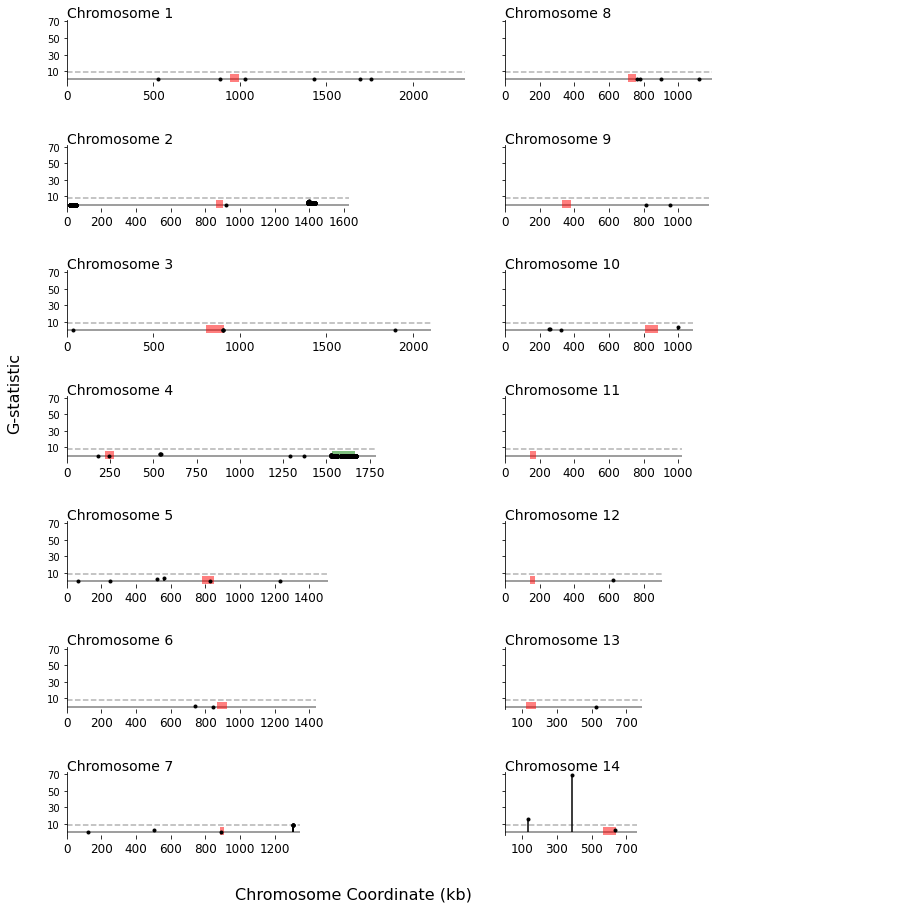

In [43]:
## Plot a Manhattan plot
fig,ax = plt.subplots(7,2,figsize=(15,15),
                      sharex=False,sharey=True)
fig.set_facecolor('w')

centy = - 0.09
centw = 10

for i,(j,c) in enumerate(chrommap.iterrows()):
    
    plt.sca(ax.ravel()[idxmap[i]])
    plt.hlines(0,0,c.Length,color='k',
               linestyle='-',alpha=0.5)
    plt.hlines(thres,0,c.Length,color='k',
               linestyle='--',alpha=0.3)
    
    
    plt.hlines(centy,c.Left,c.Right,color='r',
               linewidth=centw,alpha=0.5)
    
    if (c.Chromosome==4):
        plt.hlines(centy,*MAT,color='g',
                   linewidth=centw,alpha=0.5)
        
    temp = res[(res.Seqid==c.Seqid)]

    plt.vlines(temp.Pos,0,temp['G-stat'],color='k')
    plt.plot(temp.Pos,temp['G-stat'],'k.')
    plt.text(x=0,y=80,va='center',ha='left',
             s='Chromosome %s'%(i+1),fontsize=14)
    
    xp,xl = plt.xticks()
    
    xpz = xp[1:-1] if i < 12 else xp[1:-1][1::2]
    xpz = xpz[(xpz<c.Length)]
    plt.xticks(xpz,[int(x/1000) for x in xpz],
              fontsize=12)
    
    plt.xlim(0,np.max(chrommap.Length))
    #plt.ylim(centy-0.01,0.85)
    plt.yticks(np.arange(0,np.round(res['G-stat'].max())+11,10)[1::2])
    
    ax.ravel()[i].spines['right'].set_visible(False)
    ax.ravel()[i].spines['top'].set_visible(False)
    ax.ravel()[i].spines['bottom'].set_visible(False)

plt.subplots_adjust(wspace=0.1,hspace=1);
fig.text(0.5,0.07,'Chromosome Coordinate (kb)',
         fontsize=16,va='center',ha='right');
#fig.text(0.07,0.5,'$I$ ( G$_n$, F )',
#         rotation=90,fontsize=16);
fig.text(0.07,0.5,'G-statistic',rotation=90,fontsize=16)

savepath = '../FIGURES/QTL_G-stat_B3502_%s_filamentous_growth.png'%pheno_label
plt.savefig(savepath,
           dpi=200,bbox_inches='tight');
#plt.close()

#im = Image.open(savepath)
#im_crop = im.crop((0, 0, 2000, 2520))

#im_crop.save(savepath)

array([10., 30., 50., 70.])

In [16]:
## Find loci above threshold
sigloci = res[(res.MIobs>thres)]
sigloci

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Minlen,Depth,Type,...,B05,B06,B07,B08,B09,B10,B11,B12,B20,MIobs
485,AE017343.1,1894056,98227.7,1.0,1,G.A,1,1,5098,snp,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.335170
1924,AE017356.1,388780,80970.8,1.0,1,G.T,1,1,5055,snp,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.692993


In [17]:
## How corrilated are these loci
sigloci[samples].T.corr(method='spearman')

,485,1924
485,1.000000,0.121728
1924,0.121728,1.000000


In [18]:
## how many unique loci combos
((usnps.shape[1] - 1)**2 - (59))/2

1711.0